In [1]:
import numpy as np
from spectral import spectral
from subspace import subspace
import matplotlib.pyplot as plt
import scipy.spatial.distance as sdist
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
%matplotlib inline

In [2]:
def hybrid_clustering(problem, ground_truth, set_sigma=0.25, set_gamma=0.25, set_K=0,
                      norm_sub=True, norm_spec=True, plotter=False, printer=False):
    """perform hybrid clustering
    keyword arguments:
        problem: to cluster
        ground_truth: of the problem
        set_sigma: affinity scaling factor default=0.25
        set_gamma: convex factor default=0.25
        set_K: number of coefficents default=0=all coefficents
        norm_sub: normalize subspace array default=True
        norm_spec: normalize spectral array default=True
        plotter: plot the problem default=False
        printer: print out statments for debugging default=False
    returns:
        normalized mutual information score
    """
    # load the problem
    X = np.loadtxt(problem)
    if printer: print('problem =\n', X)
        
    # load the ground truth    
    gt = np.loadtxt(ground_truth).astype(np.int32)
    if printer: print('ground truth =\n', gt)
    
    # calculate the nuber of clusters from the ground truth
    nclusters = len(np.unique(gt))
    if printer: print('number of clusters =', nclusters)
    
    if plotter:
        if X.shape[1] == 2:
            plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in gt])
            plt.title('Ground Truth: ' + problem )
            plt.ylabel('y')
            plt.xlabel('x')
            plt.show()
    
    # number of points in each subspace
    points, n_points = np.unique(gt, return_counts=True)
    
    if printer: print('different clusters:', points, 
                      '\nnumber of points in each cluster:', n_points)
    if printer: print('\n************************************************' +
                      '\n         Start of Subspace Clustering')

    aff_sub = subspace(X, gt, set_gamma, set_K, norm_sub, plotter, printer)

    ## Spectral Clustering
    ## Let's implement a simple spectral clustering of the data
    
    if printer: print('\n************************************************' +
                      '\n         Start of Spectral Clustering')
        
    aff_spec = spectral(X, gt, n_points, set_sigma, norm_spec, plotter, printer)

    
     #######################################################################
    # Apply Hybrid method, combining the 2 matrices with matrix multiplication
    
    if printer: print('\n************************************************' +
                      '\n         Start Hybrid Clustering')
        
    hybrid_aff = np.matmul(aff_sub, aff_spec)
    if printer: print('hybrid_aff =\n', hybrid_aff)

    ## Get row sums
    hybrid_aff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,hybrid_aff)))
    if printer: print('hybrid_aff_D =\n', hybrid_aff_D)
        
    ## Normalization
    hybrid_norm = np.matmul(np.matmul(hybrid_aff_D,hybrid_aff),hybrid_aff_D)
    if printer: print('hybrid_norm =\n', hybrid_norm)
        
    if plotter:
        if X.shape[1] == 2:
            for i in range(X.shape[0]):
                for j in range(X.shape[0]):
                    if i==j: continue
#                     print(i,j)
#                     print(aff_sub[i,j])
                    if gt[i] == 0:
                        plt.plot(X[[i,j],0],X[[i,j],1], color='red', alpha=hybrid_norm[i,j])
                    else:
                        plt.plot(X[[i,j],0],X[[i,j],1], color='blue', alpha=hybrid_norm[i,j])
            plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in gt])
#             plt.title('Ground Truth: ' + problem )
            plt.title('Hybrid Connections' )
            plt.ylabel('y')
            plt.xlabel('x')
            plt.show()

    ## Might not want to show this if the data sizes (N1,N2) are large
    if plotter:
        plt.imshow(hybrid_norm)
        plt.show()

    ## Decomposition
    e_vals, e_vecs = np.linalg.eigh(hybrid_norm)
    if printer: print('e-vals =', e_vals)
    if printer: print('e-vecs =\n', e_vecs)

    ## Next Check the eigenvalues
    if printer: print('eigenvalues =', e_vals[[-1,-2,-3]])
    
    if plotter:
        plt.plot(np.linspace(1,len(e_vals),num=len(e_vals)),e_vals)
        plt.show()

    ## Perform clustering
    # pull out k of them
    Xnew = e_vecs[:,[-1,-2]]
    if printer:
        print('Xnew =', Xnew)
    # make n_clusters numer of digits
    kmeans = KMeans(n_clusters=nclusters, n_init=10).fit(Xnew)

    # If you want to see the eigen vectors...
    if plotter:
        Xone = e_vecs[kmeans.labels_==0,:]
        Xtwo = e_vecs[kmeans.labels_==1,:]
        plt.plot(Xone[:,-2],Xone[:,-1],'bo',Xtwo[:,-2],Xtwo[:,-1],'ro')
        plt.show()

    # If you want it on the PCA projection...
    if plotter:
        Xsvd = np.linalg.svd(e_vecs)
        Xone = Xsvd[0][kmeans.labels_==0,:]
        Xtwo = Xsvd[0][kmeans.labels_==1,:]
        plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')
        plt.show()

    nscore = round(normalized_mutual_info_score(gt, kmeans.labels_), 3)*100
    if nscore > 30:
        print(problem, 'Normalized M/I Score:', nscore, '%', 'sigma =', set_sigma, 'gamma =', set_gamma)

    # Plot the Subspace clustering attempt at the data
    # Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
    if plotter:
        if X.shape[1] == 2:
            plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
            plt.title('Hybrid: ' + problem + '\nNormalized Mutual Info Score: ' + str(nscore) + '%')
            plt.ylabel('Y')
            plt.xlabel('X')
            plt.show()

problem =
 [[1. 1.]
 [1. 2.]
 [9. 8.]
 [9. 9.]]
ground truth =
 [0 0 1 1]
number of clusters = 2


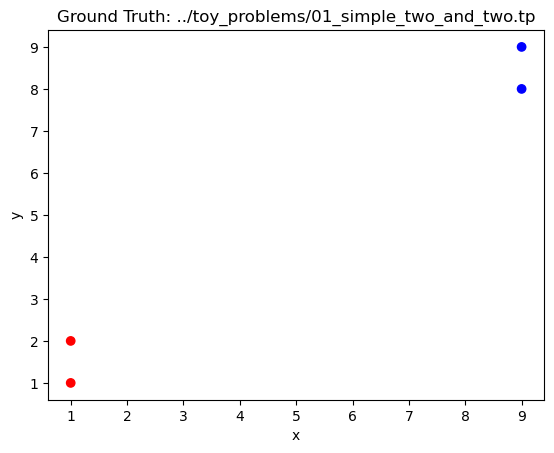

different clusters: [0 1] 
number of points in each cluster: [2 2]

************************************************
         Start of Subspace Clustering
hello from subspace
A =
 [[1. 1. 9. 9.]
 [1. 2. 8. 9.]]
shape of A = (2, 4)
coeff =
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

************************************************
            Solve for coefficents
b =
 [1. 1.]
x =
 var174
[Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ()))]
coeff =
 [[2.86891352e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.88960567e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.27283780e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.11111111e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
b =
 [1. 2.]
x =
 var217
[Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ()))]
coeff =
 [[2.86891352e-12 2.55190114e-11 0.00000000e+00 0.00000000e+00]
 [4.88960567e-12 8.66908261e-11 0.00000000e+00 0.00000000e+00]
 [1.27283780e-11 4.2

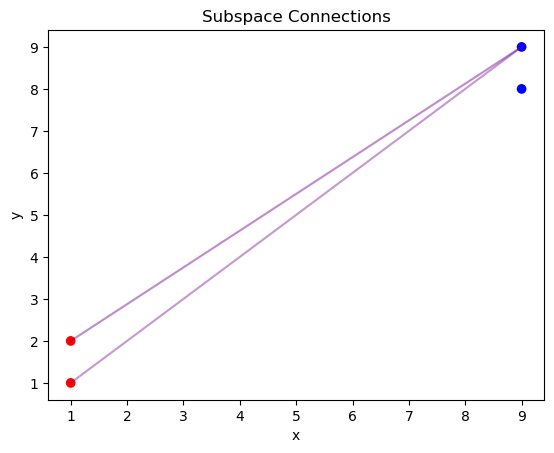

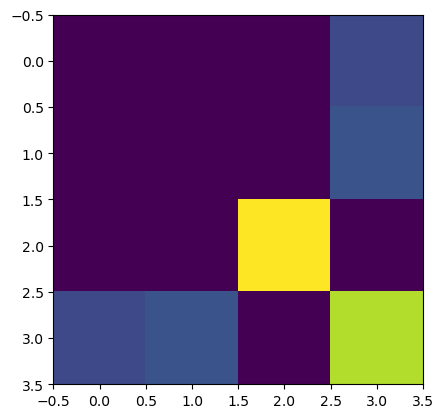


************************************************
         Start of Spectral Clustering
hello from spectral
sigma = 0.25
distance:
 [[ 0.          1.         10.63014581 11.3137085 ]
 [ 1.          0.         10.         10.63014581]
 [10.63014581 10.          0.          1.        ]
 [11.3137085  10.63014581  1.          0.        ]]
spec_aff =
 [[1.00000000e+00 3.35462628e-04 0.00000000e+00 0.00000000e+00]
 [3.35462628e-04 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 3.35462628e-04]
 [0.00000000e+00 0.00000000e+00 3.35462628e-04 1.00000000e+00]]


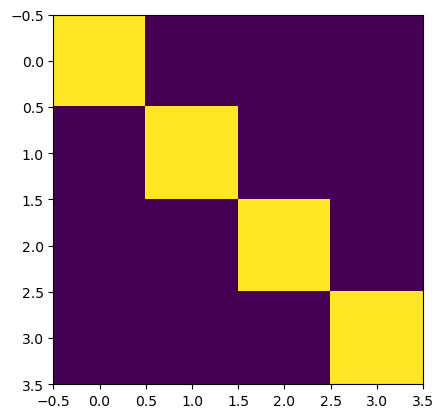

spec_aff =
 [[0.         0.00033546 0.         0.        ]
 [0.00033546 0.         0.         0.        ]
 [0.         0.         0.         0.00033546]
 [0.         0.         0.00033546 0.        ]]


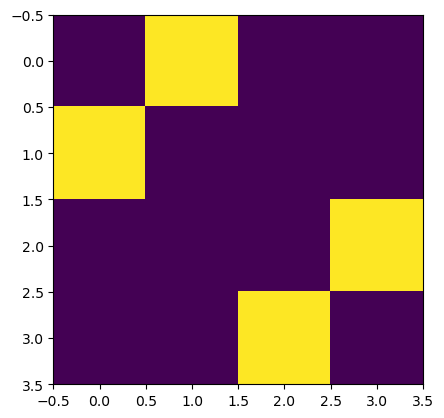

spec_aff_diag =
 [[54.59815003  0.          0.          0.        ]
 [ 0.         54.59815003  0.          0.        ]
 [ 0.          0.         54.59815003  0.        ]
 [ 0.          0.          0.         54.59815003]]


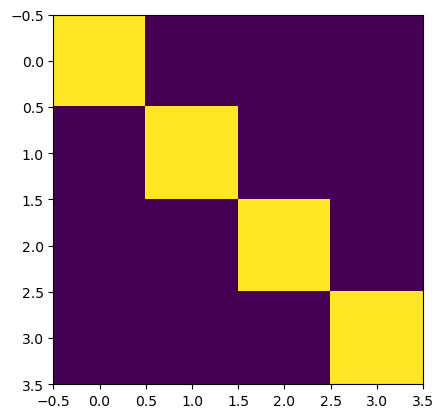

spec_norm =
 [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


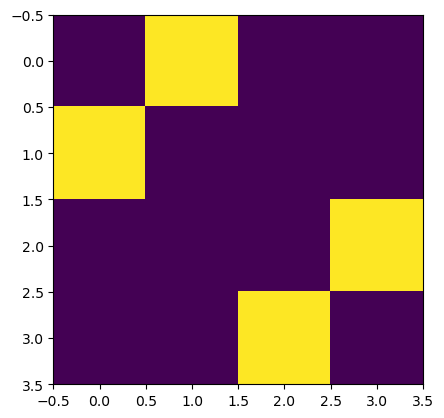

aff_spec = [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


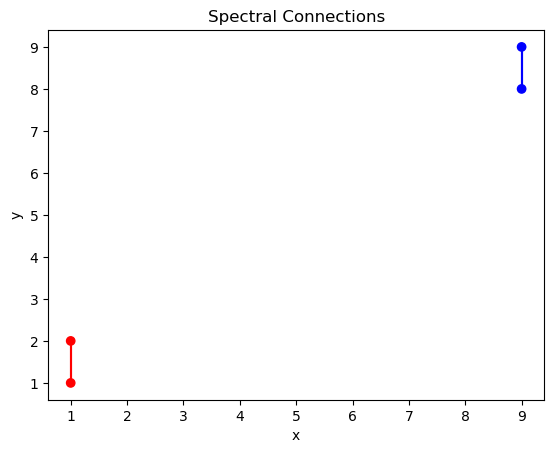


************************************************
         Start Hybrid Clustering
hybrid_aff =
 [[2.36909663e-10 5.16404434e-11 2.21760116e-01 4.21867098e-11]
 [1.16931855e-09 2.36909663e-10 2.56176828e-01 8.94428620e-11]
 [8.94428620e-11 4.21867098e-11 7.70172669e-11 1.00000000e+00]
 [2.56176828e-01 2.21760116e-01 8.85195884e-01 7.70172669e-11]]
hybrid_aff_D =
 [[1.97574129 0.         0.         0.        ]
 [0.         2.12352941 0.         0.        ]
 [0.         0.         0.85650699 0.        ]
 [0.         0.         0.         1.        ]]
hybrid_norm =
 [[9.24789581e-10 2.16659791e-10 3.75270502e-01 8.33500247e-11]
 [4.90592828e-09 1.06831502e-09 4.65938970e-01 1.89934548e-10]
 [1.51358451e-10 7.67299380e-11 5.65001923e-11 8.56506990e-01]
 [5.06139137e-01 4.70914128e-01 7.58176462e-01 7.70172669e-11]]


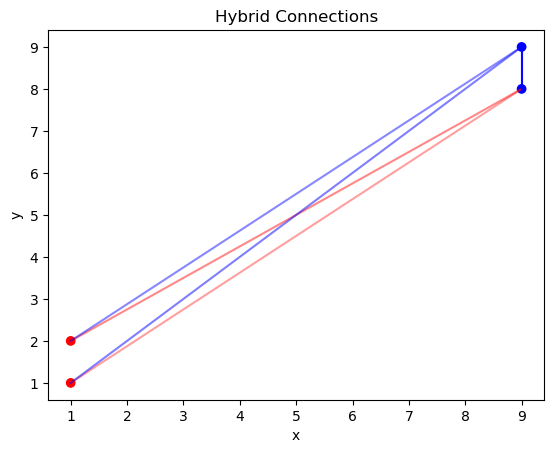

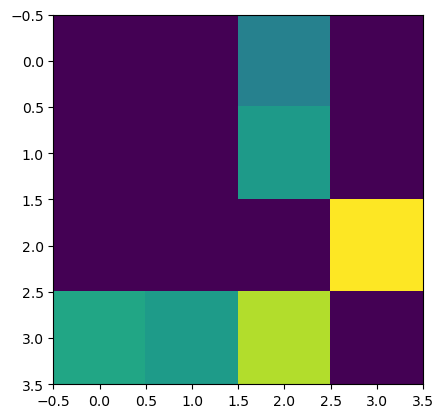

e-vals = [-1.02604507e+00 -3.90856720e-09  3.09344833e-09  1.02604507e+00]
e-vecs =
 [[ 3.48809643e-01  7.07070447e-01 -5.06670551e-01  3.48809645e-01]
 [ 3.24534059e-01 -7.06358967e-01 -5.38899153e-01  3.24534062e-01]
 [ 5.22503088e-01 -3.32925257e-02  6.72958138e-01  5.22503086e-01]
 [-7.07106782e-01  1.04441265e-10  2.85128563e-09  7.07106781e-01]]
eigenvalues = [ 1.02604507e+00  3.09344833e-09 -3.90856720e-09]


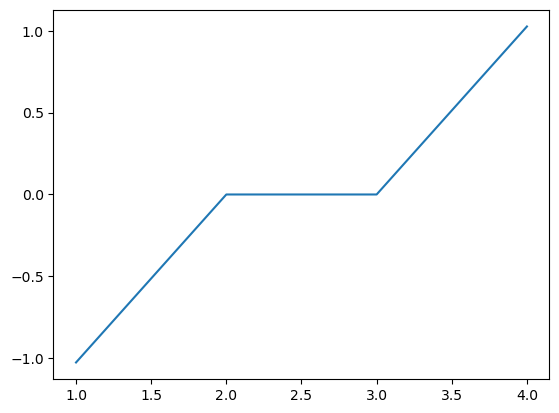

Xnew = [[ 3.48809645e-01 -5.06670551e-01]
 [ 3.24534062e-01 -5.38899153e-01]
 [ 5.22503086e-01  6.72958138e-01]
 [ 7.07106781e-01  2.85128563e-09]]


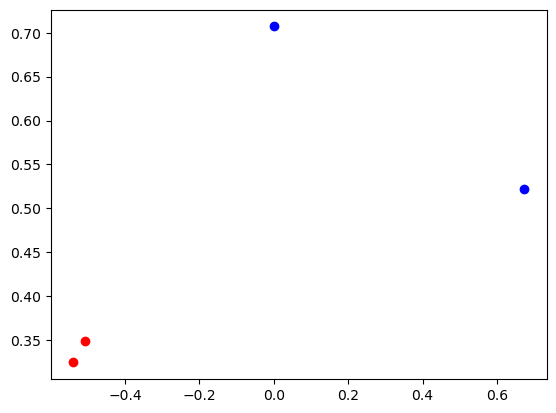

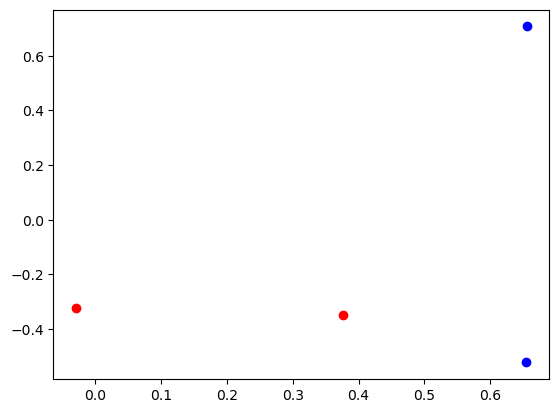

../toy_problems/01_simple_two_and_two.tp Normalized M/I Score: 100.0 % sigma = 0.25 gamma = 0.25


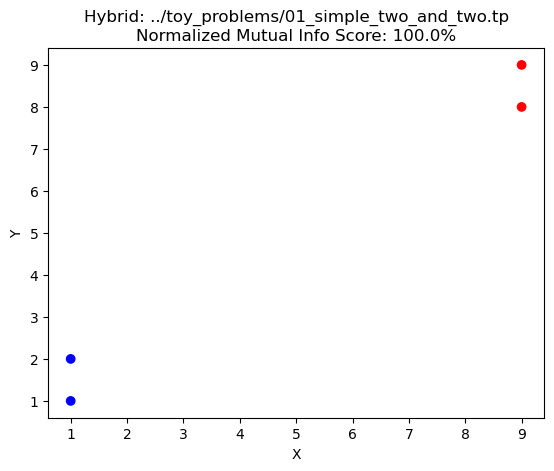

In [5]:
hybrid_clustering('../toy_problems/01_simple_two_and_two.tp', '../toy_problems/01_simple_two_and_two_ground_truth.tp',
                  set_sigma=0.25, set_gamma=0.25, set_K=0,
                  norm_sub=True, norm_spec=True, plotter=True, printer=True)